In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [6]:

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

In [10]:
# reflect an existing database into a new model

# reflect the tables

measurement_table = session.query(measurement).first()
measurement_table.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x15bc09e4950>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397'}

In [11]:

# reflect the tables
station_table = session.query(station).first()
station.__dict__


mappingproxy({'__table__': Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None),
              '__module__': 'sqlalchemy.ext.automap',
              '__doc__': None,
              '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.station'> at 15bc09aeb70>,
              '__init__': <function sqlalchemy.orm.instrumentation.__init__(self, **kwargs)>,
              'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x15bc09af2f0>,
              'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x15bc09af470>,
              'name': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x15bc09af5f0>,
              'latitude': <sqlalchemy.orm.attributes.InstrumentedAttr

# Exploratory Precipitation Analysis

In [12]:
import datetime as dt

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [14]:
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [15]:

result = session.query(measurement.date, measurement.prcp).\
   filter(measurement.date >= year_ago).all()


In [16]:
df = pd.DataFrame(result, columns= ["Date","Precipitation"])
df.set_index("Date", inplace=True)
df_sort = df.sort_values("Date", ascending=False)
clean_df = df_sort.dropna()



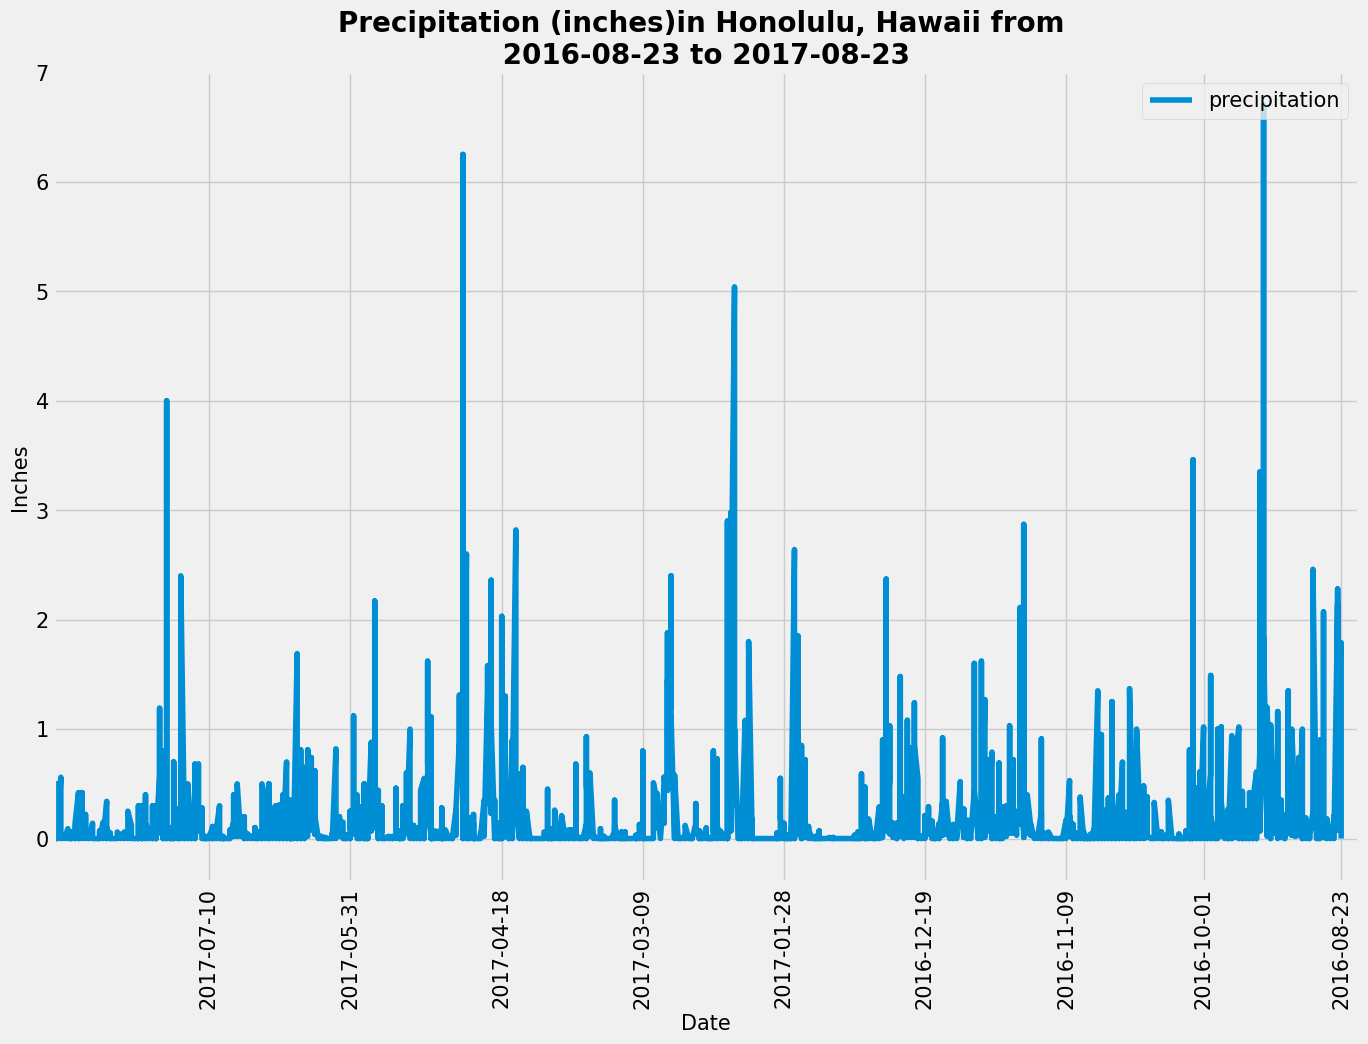

<Figure size 640x480 with 0 Axes>

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).\
   filter(measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(result, columns= ["Date","Precipitation"])

# Sort the dataframe by date
df.set_index("Date", inplace=True)
df_sort = df.sort_values("Date", ascending=False)
clean_df = df_sort.dropna()
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15, 10))
plt.plot(clean_df.index, clean_df['Precipitation'])

# Add legned 
plt.legend(['precipitation'], loc="upper right",fontsize=15)
# set x location
x = ['2016-08-23','2016-10-01', '2016-11-09','2016-12-19', '2017-01-28','2017-03-09', '2017-04-18','2017-05-31','2017-07-10'] 

# Assign xticks
plt.xticks(x, rotation='vertical',fontsize=15)
# Set Labels & Title
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.title(f"Precipitation (inches)in Honolulu, Hawaii from \n {year_ago} to 2017-08-23 ",fontsize=20, fontweight = 'bold')
plt.yticks(size=15)

# Asign xlim and ylim
plt.xlim(0,370)
plt.ylim(-0.4,7)


# Save Figure
plt.savefig("Images/Precipitation_Plot.png")
# Show plot
plt.show()
plt.tight_layout()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = clean_df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('station')
for column in columns:
   print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# Design a query to calculate the total number of stations in the dataset
number_station = session.query(station.station).count()
number_station

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

sel = [station.station, func.count(measurement.station)]
session.query(*sel).filter(station.station == measurement.station).group_by(station.station).\
order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
se = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
session.query(*se).filter(measurement.station == sel[0]).all()


[(53.0, 87.0, 73.09795396419437)]

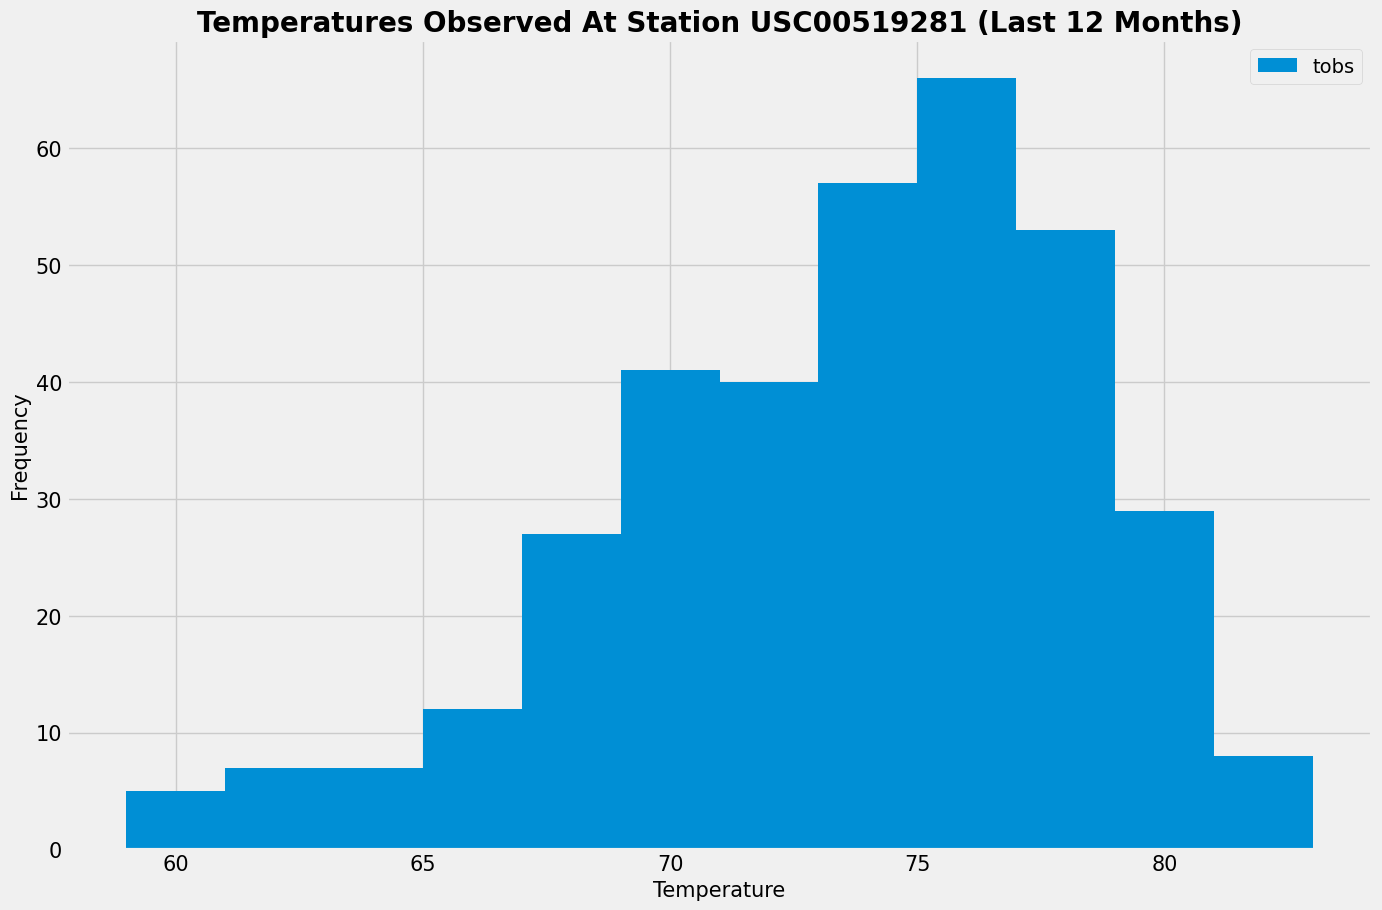

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_active = session.query(measurement.tobs).\
filter(measurement.date >= year_ago,\
       measurement.station == "USC00519281").all()

plt.figure(figsize=(15,10))
plt.hist(np.ravel(temp_active), bins=12)
plt.title('Temperatures Observed At Station USC00519281 (Last 12 Months)',fontsize=20, fontweight = 'bold')
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)
plt.show()


# Close Session

In [24]:
# Close Session
session.close()